## 20133807 Jeong Seong Woon

### Import modules

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt

### Construct autoencoder network based on CNN

In [2]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride =1, padding = 1),
            nn.ReLU(True),
            nn.MaxPool2d(3, stride =1),
            nn.Conv2d(16, 32, 2, stride = 1, padding = 1),
            nn.MaxPool2d(2, stride =1),
            nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 2, stride =1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 2, stride =1),
            nn.ReLU(True)
        )
        
    def forward(self, x):
#         print("before", x.shape)
        x = self.encoder(x)
        #print("after encoder", x.shape)
        x = self.decoder(x)
        #print("after decoder", x.shape)
        return x

In [3]:
batch_size = 50
learning_rate = 5e-4

### Implement function for adjusting learning rate

In [4]:
def adjust_lr(optimizer, epoch):
    lr = learning_rate * (0.5 ** (epoch // 10))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

### Custom DataLoader and make model, objective, optimizer

#### 1. Add noise to training data by Normal Distributed Random number

#### 2. Execute training

In [5]:
model = autoencoder().cuda()
objective = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate,
                             weight_decay=1e-4)

# custom dataloader for .npy file
class numpyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = torch.from_numpy(data).float()
        self.targets = torch.from_numpy(data).float()
        self.transform = transform
        self.noise = torch.empty(len(self.data), 1, 120, 80).normal_(mean= 0, std=0.025)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        if self.transform:
            x = self.transform(x)
            y = self.transform(y)
        x = x+self.noise[index]
        
        return x, y

    
    def __len__(self):
        return len(self.data)

loss_train_mean_list = []
loss_train_std_list = []

if __name__ == '__main__':

    NUM_EPOCH       = 100
    
    transform       = transforms.Compose([
                                    transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.ToTensor(),
                                ])

    # for training
    traindata       = np.load('train.npy')
    traindataset    = numpyDataset(traindata, transform)    
    trainloader     = DataLoader(traindataset, batch_size=batch_size, shuffle=False, num_workers=0)
    loss_train_mean_old = 0
    for epoch in range(NUM_EPOCH):
        loss_train_list =[]
        for batch_idx, (data,target) in enumerate(trainloader):
#             adjust_lr(optimizer, epoch)
            image   = data
            image = Variable(image).cuda()
            target = Variable(target).cuda()
            output = model(image)
            loss = objective(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train_list.append(loss.item())
        
        loss_train_mean = np.mean(loss_train_list)
        loss_train_mean_list.append(loss_train_mean)
        loss_train_std = np.std(loss_train_list)
        loss_train_std_list.append(loss_train_std)
        if abs(loss_train_mean - loss_train_mean_old) < 1e-5:
            break
        loss_train_mean_old = loss_train_mean
        print('epoch [{}], loss:(training){:.5f}'.format(epoch+1, loss_train_mean))

epoch [1], loss:(training)0.00429
epoch [2], loss:(training)0.00151
epoch [3], loss:(training)0.00119
epoch [4], loss:(training)0.00103
epoch [5], loss:(training)0.00096
epoch [6], loss:(training)0.00090
epoch [7], loss:(training)0.00086
epoch [8], loss:(training)0.00083
epoch [9], loss:(training)0.00081
epoch [10], loss:(training)0.00079
epoch [11], loss:(training)0.00078
epoch [12], loss:(training)0.00076
epoch [13], loss:(training)0.00075
epoch [14], loss:(training)0.00074
epoch [15], loss:(training)0.00073


### Export resulted test file through trained model

In [6]:
#for testing
testdata        = np.load('test.npy')
testdataset     = numpyDataset(testdata, transform)
testloader      = DataLoader(testdataset, batch_size=1, shuffle=False, num_workers=0)

result_for_submit = None    # this is for submit file

for batch_idx, data in enumerate(testloader):
    image = Variable(data[1]).cuda()
    temp = Variable(data[0]).cuda()
    result_of_test = model(image)  
    
    if batch_idx == 0:
        result_for_submit = result_of_test
    else:
        try:
            result_for_submit = torch.cat([result_for_submit, result_of_test], dim=0)

        except RuntimeError:
            transposed = torch.transpose(result_of_test, 2, 3)
            result_for_submit = torch.cat([result_for_submit, transposed], dim=0)

# the submit_file.shape must be (400,1,120,80) 
submit_file = result_for_submit.detach().cpu().numpy()
np.save('JeongSeongWoon.npy', submit_file)

### Plot graph

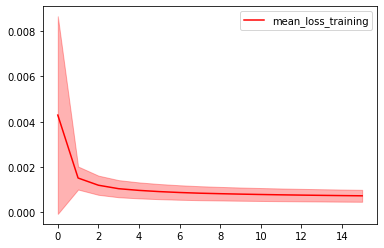

In [7]:
np_loss_train_mean = np.array(loss_train_mean_list)
np_loss_train_std = np.array(loss_train_std_list)

plt.figure(1)
plt.plot(np_loss_train_mean,label='mean_loss_training',color= 'r')
plt.fill_between(np.arange(len(np_loss_train_mean)),\
                 np_loss_train_mean-np_loss_train_std,\
                 np_loss_train_mean+np_loss_train_std,color='r',alpha=0.3)
plt.legend()